## *GCN*

---



This notebook implements a complete Graph Convolutional Network (GCN) pipeline for a 3-class potency classification task (Low, Medium, High). It includes hyperparameter tuning, ensemble averaging, final model training and test evaluation

**Prerequisites:**

* PyTorch & PyTorch Geometric
* scikit-learn
* pandas, numpy, matplotlib
* RDKit (only for feature extraction)
* GPU recommended

**Install requirements:**

pip install torch torch-geometric scikit-learn pandas numpy matplotlib rdkit-pypi

**Step 1: Environment & Setup**

Seed all random generators for reproducibility.

Define paths for data splits and output.

Detect GPU/CPU.

**Step 2: Model Definition**

Define a simple 2-layer GCN with dropout and a global pooling head

**Step 3: Evaluation Function**

evaluate(model, loader) returns concatenated logits and true labels.

**Step 4: Hyperparameter Sweep (10-Fold CV)**

* Grid search over hidden_dim, dropout, lr

* For each config, perform 10-fold CV:

  *  Train each fold for 50 epochs

  * Compute per-fold metrics on the validation set:

    * AUC-ROC (one-vs-rest)

    * Balanced Accuracy

* Record mean ± std for both metrics

* Save results to gcn_sweep_results.csv

**Step 5: Retraining & Validation (10-Fold CV)**

* Select best hyperparameters by highest mean balanced accuracy

* Retrain each fold with early stopping (patience=10)

* Save the best checkpoint per fold (fold{i}_model.pt)

* Compute per-fold metrics:

 * Accuracy, Precision, Recall, F1-Score, AUC-ROC

* Save summary to gcn_crossval_summary.csv

**Step 6: Cross-Validation Results Visualization**
* Load gcn_crossval_summary.csv

* Plot bar charts of each metric (accuracy, precision, recall, F1, AUC-ROC) across folds

* Print overall mean ± std for each metric

**Step 7: Ensemble Averaging**
* Load each fold’s checkpoint and run on the test set

* Average the raw logits across folds

* Save predictions (gcn_ensemble_preds.csv)

* Plot:

 * Confusion matrix (labels: Low, Medium, High)

* Per-class ROC curves with AUC in legend

**Step 8: Final Model Training & Test Evaluation**
* Merge all train+val folds, reserve 10% for a small validation split

* Train final GCN with early stopping & LR scheduler (ReduceLROnPlateau)

* Evaluate on the held-out test set:

 * Accuracy, Precision, Recall, F1-Score, AUC-ROC

* Plot final confusion matrix & ROC curves

* Save:

 * gcn_final_metrics.csv

 * final_confusion_matrix.png

 * final_auc_roc.png



**Step 9: Contrast ensemble GCN vs. final GCN**

In [ ]:
# GCN-based Classification Pipeline

# Step 1: Environment and Setup
import os, random
import torch, torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import (
    roc_auc_score, balanced_accuracy_score,
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedShuffleSplit

Mounted at /content/drive


In [ ]:
# Seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark    = False

def seed_worker(worker_id):
    ws = seed + worker_id
    np.random.seed(ws)
    random.seed(ws)

generator = torch.Generator().manual_seed(seed)
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")

task       = "classification"
num_classes= 3
kfold      = 10

# Paths

base_path = f"../../4_train_test_split/10fold_cv/{task}/"
results_dir = f"GCN_results/{task}_{kfold}fold/"
os.makedirs(results_dir, exist_ok=True)

################### If using google colab
#from google.colab import drive
#drive.mount('/content/drive')
#root_dir    = "/content/drive/MyDrive/GNN_model_TRPM8_Drug_Potency_prediction/GNN_model_TRPM8_Drug_Potency_prediction-Dolapo"
#base_path   = os.path.join(root_dir, "4_train_test_split/10fold_cv/classification")  # adjust if your splits live elsewhere
#results_dir = os.path.join(root_dir, "GCN_results/classification_10fold")
#os.makedirs(results_dir, exist_ok=True)
##################


In [ ]:
# Step 2: Define GCN Model
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.0):
        super().__init__()
        self.conv1   = GCNConv(in_dim, hidden_dim)
        self.conv2   = GCNConv(hidden_dim, hidden_dim)
        self.dropout = dropout
        self.lin     = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, data.batch)
        return self.lin(x)

In [ ]:
# Step 3: Evaluation helper
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out   = model(batch)
            preds.append(out.cpu())
            labels.append(batch.y.cpu())
    return torch.cat(preds), torch.cat(labels)

In [ ]:
# Step 4: Hyperparameter Sweep (10-Fold CV)
hidden_dims = [64, 128]
dropouts    = [0.0, 0.2]
lrs         = [1e-3, 5e-4]

sweep = []
for hd in hidden_dims:
    for dp in dropouts:
        for lr in lrs:
            auc_scores, bal_scores = [], []
            for fold in range(kfold):
                # load train/val with weights_only disabled
                tr_path = os.path.join(base_path, f"{task}_train_fold{fold}.pt")
                vl_path = os.path.join(base_path, f"{task}_val_fold{fold}.pt")
                tr_data = torch.load(tr_path, weights_only=False)
                vl_data = torch.load(vl_path, weights_only=False)

                tr_loader = DataLoader(
                    tr_data, batch_size=32, shuffle=True,
                    worker_init_fn=seed_worker, generator=generator
                )
                vl_loader = DataLoader(vl_data, batch_size=32)

                # init model & optimizer
                model     = GCN(
                    in_dim=tr_data[0].x.size(1),
                    hidden_dim=hd,
                    out_dim=num_classes,
                    dropout=dp
                ).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # train for 50 epochs
                for epoch in range(50):
                    model.train()
                    for b in tr_loader:
                        b = b.to(device)
                        optimizer.zero_grad()
                        loss = F.cross_entropy(model(b), b.y.long())
                        loss.backward()
                        optimizer.step()

                # eval
                preds, labels = evaluate(model, vl_loader)
                y_true  = labels.numpy().astype(int)
                y_probs = F.softmax(preds, dim=1).numpy()
                y_pred  = preds.argmax(dim=1).numpy()

                auc_scores.append(roc_auc_score(
                    label_binarize(y_true, classes=np.arange(num_classes)),
                    y_probs, multi_class='ovr'
                ))
                bal_scores.append(balanced_accuracy_score(y_true, y_pred))

            sweep.append({
                "hidden_dim": hd,
                "dropout":    dp,
                "lr":         lr,
                "mean_auc":   np.mean(auc_scores),
                "std_auc":    np.std(auc_scores),
                "mean_bal_acc": np.mean(bal_scores),
                "std_bal_acc":  np.std(bal_scores),
            })
            print(f"hd={hd} dp={dp} lr={lr} → AUC {np.mean(auc_scores):.4f}, BalAcc {np.mean(bal_scores):.4f}")

sweep_df = pd.DataFrame(sweep)
sweep_df.to_csv(os.path.join(results_dir, "gcn_sweep_results.csv"), index=False)
print("Saved hyperparameter sweep")


hd=64 dp=0.0 lr=0.001 → AUC 0.7353, BalAcc 0.4733
hd=64 dp=0.0 lr=0.0005 → AUC 0.7152, BalAcc 0.4457
hd=64 dp=0.2 lr=0.001 → AUC 0.7305, BalAcc 0.4790
hd=64 dp=0.2 lr=0.0005 → AUC 0.6955, BalAcc 0.4677
hd=128 dp=0.0 lr=0.001 → AUC 0.7515, BalAcc 0.4786
hd=128 dp=0.0 lr=0.0005 → AUC 0.7203, BalAcc 0.4654
hd=128 dp=0.2 lr=0.001 → AUC 0.7464, BalAcc 0.4782
hd=128 dp=0.2 lr=0.0005 → AUC 0.7187, BalAcc 0.4712
Saved hyperparameter sweep


In [ ]:
# Step 5: Retrain Each Fold & Save CV Summary
best = sweep_df.loc[sweep_df["mean_bal_acc"].idxmax()]
best_hd, best_dp, best_lr = int(best.hidden_dim), float(best.dropout), float(best.lr)

fold_metrics = []
for fold in range(kfold):
    tr_data = torch.load(
        os.path.join(base_path, f"{task}_train_fold{fold}.pt"),
        weights_only=False
    )
    vl_data = torch.load(
        os.path.join(base_path, f"{task}_val_fold{fold}.pt"),
        weights_only=False
    )

    tr_loader = DataLoader(
        tr_data, batch_size=32, shuffle=True,
        worker_init_fn=seed_worker, generator=generator
    )
    vl_loader = DataLoader(vl_data, batch_size=32)

    model     = GCN(tr_data[0].x.size(1), best_hd, num_classes, dropout=best_dp).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
    best_vloss, patience = float("inf"), 0

    for epoch in range(1, 101):
        model.train()
        tloss = 0
        for b in tr_loader:
            b = b.to(device)
            optimizer.zero_grad()
            out  = model(b)
            loss = F.cross_entropy(out, b.y.long())
            loss.backward()
            optimizer.step()
            tloss += loss.item()

        preds, labels = evaluate(model, vl_loader)
        vloss = F.cross_entropy(preds, labels.long()).item()

        if vloss < best_vloss:
            best_vloss, patience = vloss, 0
            torch.save(
                model.state_dict(),
                os.path.join(results_dir, f"fold{fold+1}_model.pt")
            )
        else:
            patience += 1
            if patience >= 10:
                break

    y_true = labels.numpy().astype(int)
    y_pred = preds.argmax(dim=1).numpy()
    acc    = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    auc_v = roc_auc_score(
        label_binarize(y_true, classes=np.arange(num_classes)),
        F.softmax(preds, dim=1).numpy(),
        multi_class='ovr'
    )

    fold_metrics.append({
        "fold": fold+1,
        "accuracy":    acc,
        "precision":   prec,
        "recall":      rec,
        "f1_score":    f1,
        "auc_roc":     auc_v
    })

cv_df = pd.DataFrame(fold_metrics)
cv_df.to_csv(
    os.path.join(results_dir, "gcn_crossval_summary.csv"),
    index=False
)
print("Saved CV summary")



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Saved CV summary


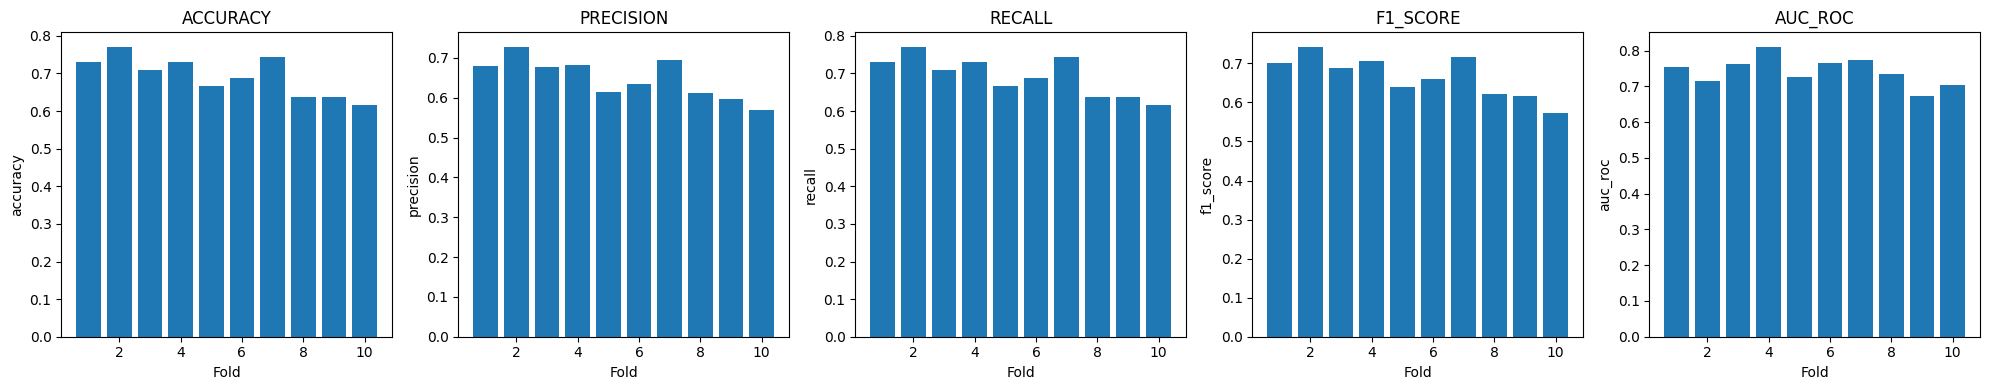

In [ ]:
# Step 6: Plot CV Results
cv_df = pd.read_csv(os.path.join(results_dir, "gcn_crossval_summary.csv"))
metrics = ["accuracy","precision","recall","f1_score","auc_roc"]
fig, axs = plt.subplots(1, len(metrics), figsize=(20,4))
for i, m in enumerate(metrics):
    axs[i].bar(cv_df["fold"], cv_df[m])
    axs[i].set_title(m.upper()); axs[i].set_xlabel("Fold"); axs[i].set_ylabel(m)
plt.tight_layout(); plt.show()

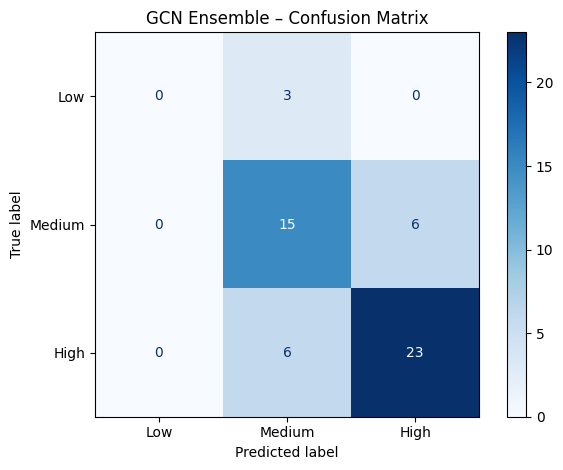

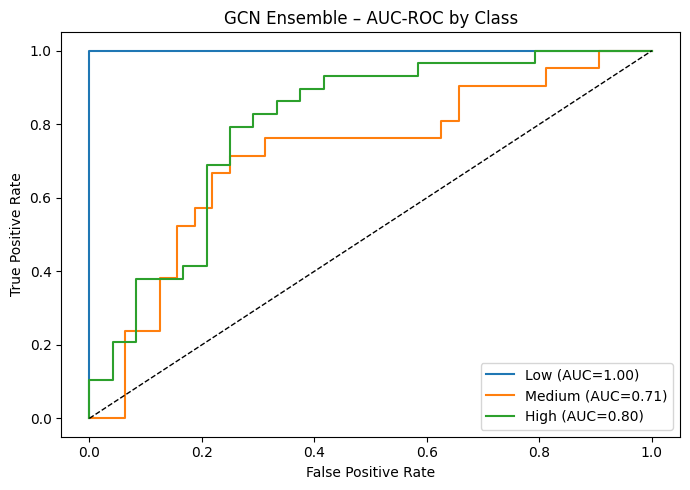

In [ ]:
# Step 7: Ensemble Averaging on Test Set
test_data = torch.load(
    os.path.join(base_path, f"{task}_test.pt"),
    weights_only=False
)
test_loader = DataLoader(test_data, batch_size=32)
all_preds = []

for fold in range(kfold):
    model = GCN(
        test_data[0].x.size(1), best_hd, num_classes, dropout=best_dp
    ).to(device)
    model.load_state_dict(
        torch.load(
            os.path.join(results_dir, f"fold{fold+1}_model.pt"),
            weights_only=False
        )
    )
    model.eval()
    preds_fold = []
    with torch.no_grad():
        for b in test_loader:
            preds_fold.append(model(b.to(device)).cpu())
    all_preds.append(torch.cat(preds_fold))

avg_preds = torch.stack(all_preds).mean(0)
y_true    = torch.cat([d.y for d in test_data]).numpy().astype(int)
y_pred    = avg_preds.argmax(dim=1).numpy()
pd.DataFrame({"True": y_true, "Pred": y_pred})\
  .to_csv(os.path.join(results_dir, "gcn_ensemble_preds.csv"), index=False)

# Confusion matrix
class_names = ["Low", "Medium", "High"]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(cmap="Blues", xticks_rotation=0)
plt.title("GCN Ensemble – Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

# AUC by class
y_probs    = F.softmax(avg_preds, dim=1).numpy()
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

plt.figure(figsize=(7,5))
for i, name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.2f})")

plt.plot([0,1], [0,1], "k--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("GCN Ensemble – AUC-ROC by Class")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | TrainLoss 0.8896 | ValLoss 0.8657
Epoch 002 | TrainLoss 0.8488 | ValLoss 0.8275
Epoch 003 | TrainLoss 0.8047 | ValLoss 0.7958
Epoch 004 | TrainLoss 0.7816 | ValLoss 0.7721
Epoch 005 | TrainLoss 0.7633 | ValLoss 0.7481
Epoch 006 | TrainLoss 0.7527 | ValLoss 0.7344
Epoch 007 | TrainLoss 0.7427 | ValLoss 0.7172
Epoch 008 | TrainLoss 0.7408 | ValLoss 0.7217
Epoch 009 | TrainLoss 0.7243 | ValLoss 0.6984
Epoch 010 | TrainLoss 0.7179 | ValLoss 0.7091
Epoch 011 | TrainLoss 0.7160 | ValLoss 0.7549
Epoch 012 | TrainLoss 0.7166 | ValLoss 0.6879
Epoch 013 | TrainLoss 0.7163 | ValLoss 0.6879
Epoch 014 | TrainLoss 0.7096 | ValLoss 0.6785
Epoch 015 | TrainLoss 0.7085 | ValLoss 0.6786
Epoch 016 | TrainLoss 0.7030 | ValLoss 0.6993
Epoch 017 | TrainLoss 0.7142 | ValLoss 0.6818
Epoch 018 | TrainLoss 0.7018 | ValLoss 0.6755
Epoch 019 | TrainLoss 0.6994 | ValLoss 0.6725
Epoch 020 | TrainLoss 0.7051 | ValLoss 0.6730
Epoch 021 | TrainLoss 0.6984 | ValLoss 0.6692
Epoch 022 | TrainLoss 0.6985 | Val

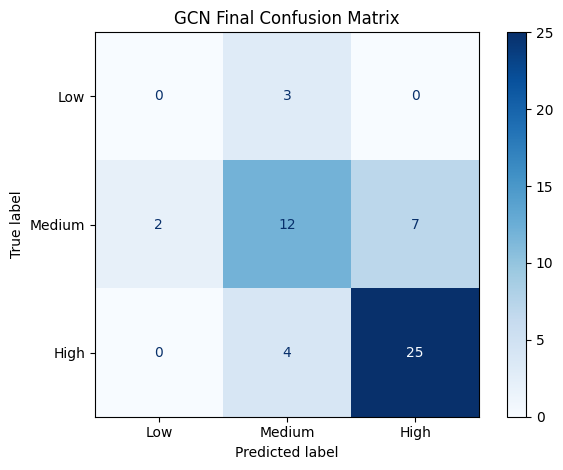

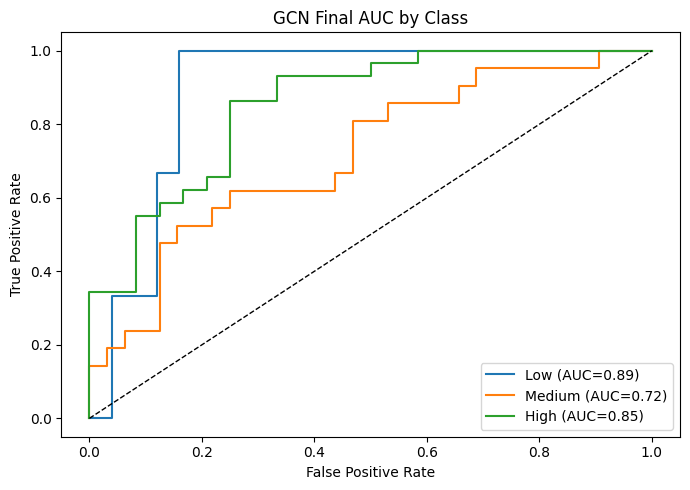

In [ ]:
# Step 8: Final Model Training on Combined Data and Test Eval
# Merge all train+val
all_data = []
for f in range(kfold):
    all_data += torch.load(
        os.path.join(base_path, f"{task}_train_fold{f}.pt"),
        weights_only=False
    )
    all_data += torch.load(
        os.path.join(base_path, f"{task}_val_fold{f}.pt"),
        weights_only=False
    )

labels = [int(d.y.item()) for d in all_data]
sss    = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)
tr_idx, vl_idx = next(sss.split(all_data, labels))
train_split   = [all_data[i] for i in tr_idx]
val_split     = [all_data[i] for i in vl_idx]

tr_loader = DataLoader(
    train_split, batch_size=32, shuffle=True,
    worker_init_fn=seed_worker, generator=generator
)
vl_loader = DataLoader(val_split, batch_size=32)

model     = GCN(all_data[0].x.size(1), best_hd, num_classes, dropout=best_dp).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=5, factor=0.5, verbose=True
)

best_vloss, patience = float("inf"), 0
for epoch in range(1,301):
    model.train()
    t_loss = 0
    for b in tr_loader:
        b = b.to(device)
        optimizer.zero_grad()
        out  = model(b)
        loss = F.cross_entropy(out, b.y.long())
        loss.backward(); optimizer.step()
        t_loss += loss.item()

    preds, labels = evaluate(model, vl_loader)
    vloss = F.cross_entropy(preds, labels.long()).item()
    scheduler.step(vloss)

    if vloss < best_vloss:
        best_vloss, patience = vloss, 0
        torch.save(
            model.state_dict(),
            os.path.join(results_dir, "gcn_final_model.pt")
        )
    else:
        patience += 1
        if patience >= 10:
            break
    print(
        f"Epoch {epoch:03d} | "
        f"TrainLoss {t_loss/len(tr_loader):.4f} | "
        f"ValLoss {vloss:.4f}"
    )

# Test evaluation
model.load_state_dict(
    torch.load(
        os.path.join(results_dir, "gcn_final_model.pt"),
        weights_only=False
    )
)
test_loader = DataLoader(
    torch.load(
        os.path.join(base_path, f"{task}_test.pt"),
        weights_only=False
    ),
    batch_size=32
)
preds, labels = evaluate(model, test_loader)
y_true = labels.numpy().astype(int)
y_pred = preds.argmax(dim=1).numpy()
probs  = F.softmax(preds, dim=1).numpy()

acc  = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted'
)
auc_f = roc_auc_score(
    label_binarize(y_true, classes=np.arange(num_classes)),
    probs, multi_class='ovr'
)

# Save final metrics
final_metrics = {
    "accuracy": acc,
    "precision": prec,
    "recall": rec,
    "f1_score": f1,
    "auc_roc": auc_f
}
pd.DataFrame(final_metrics, index=[0])\
  .to_csv(os.path.join(results_dir, "gcn_final_metrics.csv"), index=False)
print(" Final metrics:", final_metrics)

# Final confusion matrix & AUC curves
num_classes = len(class_names)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(cmap="Blues", xticks_rotation=0)
plt.title("GCN Final Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

# 3) Final AUC-ROC curves
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
plt.figure(figsize=(7,5))
for i, name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.2f})")

plt.plot([0,1], [0,1], "k--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("GCN Final AUC by Class")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

##############
# Step 9: Baseline QSAR Comparison
# baseline = pd.read_csv(
#     os.path.join(root_dir, "6_baseline_comparison/baseline_metrics.csv")
# )
# comp = pd.DataFrame({
#     "GCN_Final": [acc],
#     "Baseline_QSAR": [baseline["accuracy"].iloc[0]]
# }, index=["Accuracy"])
# display(comp)


In [ ]:
# Step 9
# Paths to outputs
fin_met_csv      = os.path.join(results_dir, "gcn_final_metrics.csv")
ensemble_preds   = os.path.join(results_dir, "gcn_ensemble_preds.csv")

# Load them
final_df    = pd.read_csv(fin_met_csv)            # has columns accuracy, precision, recall, f1_score, auc_roc
ens_df      = pd.read_csv(ensemble_preds)         # has columns True, Pred

#Compute ensemble’s accuracy
ensemble_acc = accuracy_score(ens_df["True"], ens_df["Pred"])

#Pull out  GCN’s final accuracy
gcn_acc      = final_df.loc[0, "accuracy"]

# Comparison table
comp = pd.DataFrame({
    "Ensemble GCN": [ensemble_acc],
    "Final GCN":    [gcn_acc]
}, index=["Accuracy"])


display(comp)

,Ensemble GCN,Final GCN
Accuracy,0.716981,0.698113
